In [1]:
import os
import glob
import itertools
import numpy as np
import xarray as xr
from scipy.ndimage import rotate
from scipy.integrate import cumtrapz

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)
    
from tools.e5tools import *
from orographicConvectionTheory.orographicConvectionTheory import *
from mountainUtils import *
km_per_degreelat = 6370*np.pi/180
mnths=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']


import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

xr.set_options(display_style='text') 

In [2]:
from dask.distributed import Client
client=Client()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42511 instead
  http_address["port"], self.http_server.port


# Functions, data loading

In [8]:
def get_binned(a,b,bins):
    bins=bins[(bins>float(a.min()))&(bins<float(a.max()))]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means

def get_subspells(condition,spell_length):
    """from a time series of 0s and 1s, find the longest series of 1s (indices of beginnings, ends+1 and lengths)"""
    days_ext = np.concatenate(([0.],condition,[0.]))
    days_start = np.where(days_ext[1:-1]-days_ext[:-2]>0)[0]
    days_end = np.where(days_ext[2:]-days_ext[1:-1]<0)[0]+1
    spell_lengths = days_end-days_start
    sub_spell_start   = []
    sub_spell_end     = []
    sub_spell_lengths = []
    for i,sl in enumerate(spell_lengths):
        r = sl//spell_length
        if r>=1:
            ssl = sl//r
            sub_spell_start += [days_start[i]+j*ssl for j in range(r)]
            sub_spell_end += [days_start[i]+(j+1)*ssl for j in range(r-1)]+[days_end[i]]
            sub_spell_lengths += [ssl for j in range(r-1)]+[ssl+sl%r]
    return sub_spell_start,sub_spell_end,sub_spell_lengths

def monthsel(month,monthinf,monthsup):
    return (np.mod(month - monthinf,12) < np.mod(monthsup - monthinf,12)) & (np.mod(monthsup - month,12) <= np.mod(monthsup - monthinf,12))

In [9]:
landmask=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")
era5100u=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")
era5pr_hourly = xr.open_mfdataset(sorted(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.generated_tp/ERA5_IVT_tp_reanalysis_*.nc"))[22:-3]).tp


In [10]:
mountains=         {"vietnam"    :([102,115,10,19.5],"Annamite range (Vietnam)",240,10,800.),
                    "ghats"      :([68,80,7.5,17]   ,"Western Ghats"           ,70 ,6 ,900.),
                    "madagascar" :([40,60,-25,-12]  ,"Madagascar"              ,280,3 ,1350.),
                    "myanmar"    :([80,102,7,27]    ,"Myanmar"                 ,60 ,7 ,1700.),
                    "newbritain" :([148,155,-12,0]  ,"New Britain"             ,320,7 ,450.),
                    "philippines":([118,130,10,22]  ,"Philippines"             ,225,12,850.),
                    "sumatra"    :([90,110,-6,6]    ,"Bukit Barisan (Sumatra)" ,70 ,11,1100.),
                    "malaysia"   :([97,107,1,10]    ,"Malaysia"                ,225,11,600.),
                    "myanmarwide"     :([85,105,12,29]  ,"Myanmar"     ,50 ,7 ,1700.),
                    "newbritainwide"  :([146,155,-12,0] ,"New Britain" ,320,7 ,450. ),
                   }

precip_boxes = {"vietnam"    :[107  ,  19  , 110.5, 14   ,2  ],
                "ghats"      :[ 75  ,   9  ,  72.5, 16   ,2  ],
                "madagascar" :[ 52  , -14.5,  49  , -24.5,2.5],
                "myanmar"    :[ 98  ,  11  ,  90  , 21   ,4  ],
                "newbritain" :[154  , - 6  , 150  , -8   ,2  ],
                "philippines":[123.5,  19  , 127  , 11   ,3  ],
                "sumatra"    :[ 98.5, - 2  ,  96  , 2    ,2.5],
                "malaysia"   :[100.5,  10  , 105  , 4    ,2  ],
                "myanmarwide"    :[ 98  ,  11  ,  90  , 21   ,4  ],
                "newbritainwide" :[154  , - 6  , 150  , -8   ,2  ],
               }

months_perregion = {"vietnam"    :['10'],
                    "myanmarwide"    :['06','07','08'],
                    "newbritainwide" :['06','07','08'],
                   }

wind_boxes         =   {"vietnam"    :[109, 111, 16, 18]    ,
                        "myanmarwide"    :[88,92,15,19]      ,
                        "newbritainwide" :[152,154,-9,-7]    ,
                       }



In [18]:
%%time
Vietnam         = MountainRange("vietnam"        ,*mountains["vietnam" ])
Myanmarwide     = MountainRange("myanmarwide"    ,*mountains["myanmarwide"    ])
Newbritainwide  = MountainRange("newbritainwide" ,*mountains["newbritainwide" ])

for MR in (Vietnam,Myanmarwide,Newbritainwide):
    MR.set_boxes(0,wind_boxes[MR.name],precip_boxes[MR.name])
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u)
    MR.set_2dvar('VAR_100V',era5100v)
    MR.set_2dvar('Z',orogm)
    MR.set_uperp()
    
    MR.vars['T_HOURLY'] = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_130_t.ll025sc.%i%s.%s.zarr"%(year,month,MR.name)) for year,month in itertools.product(range(2001,2016),months_perregion[MR.name])),dim='time').T
    MR.vars['U_HOURLY'] = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_131_u.ll025sc.%i%s.%s.zarr"%(year,month,MR.name)) for year,month in itertools.product(range(2001,2016),months_perregion[MR.name])),dim='time').U
    MR.vars['V_HOURLY'] = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_132_v.ll025sc.%i%s.%s.zarr"%(year,month,MR.name)) for year,month in itertools.product(range(2001,2016),months_perregion[MR.name])),dim='time').V
    MR.vars['UPERP_HOURLY'] = crossslopeflow(MR.vars['U_HOURLY'], MR.vars['V_HOURLY'],MR.angle)
    MR.vars['W_HOURLY'] = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_135_w.ll025sc.%i%s.%s.zarr"%(year,month,MR.name)) for year,month in itertools.product(range(2001,2016),months_perregion[MR.name])),dim='time').W
    MR.vars['ERA5PR_HOURLY'] = sel_box_month(era5pr_hourly,MR.box,0)

    climcapst_temp = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/L3_CLIMCAPS_QCC.air_temp.2002-2015.%s.%s.zarr"%(month,MR.name)).air_temp for month in months_perregion[MR.name]),dim="time").sortby('time')
    MR.vars['CLIMCAPST_DAILY'] = climcapst_temp.assign_coords(level=climcapst_temp.air_pres/100).swap_dims({'air_pres':'level'})

    MR.vars['GPMPR_DAILY'] = sel_box_month(xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.%s.%s.zarr"%(month,MR.name)).precipitationCal for month in months_perregion[MR.name]),dim="time").sortby('time'),MR.box,0).transpose('time','latitude','longitude')
    #MR.set_othervar('GPMPR_DAILY',xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.%s.%s.zarr"%(month,MR.name)).precipitationCal for month in months_perregion[MR.name]),dim="time").sortby('time'))
    precipmask = tilted_rect(MR.vars['GPMPR_DAILY'],*MR.box_tilted)*landmask.interp_like(MR.vars['GPMPR_DAILY'])
    MR.vars['GPMPR_ABOVE_DAILY'] = spatial_mean(MR.vars['GPMPR_DAILY'],mask=precipmask).load()

    era5uitg_daily = MR.vars['UPERP_HOURLY'].sel(level=slice(700,1100)).resample(time='1D').mean().mean('level')
    era5uitg_daily = era5uitg_daily.sel(time=(monthsel(era5uitg_daily['time.month'],int(months_perregion[MR.name][0]),int(months_perregion[MR.name][-1])+1)))
    MR.vars['UPERPITG_UPSTREAM_DAILY']=sel_box_month(era5uitg_daily,MR.box_above,0).mean(['latitude','longitude']).load()


CPU times: user 2min 35s, sys: 14.1 s, total: 2min 49s
Wall time: 4min 29s


In [19]:
Vietnam       .center = 0.6
Myanmarwide   .center = 0.5
Newbritainwide.center = 0.6
Vietnam       .width = 0.15
Myanmarwide   .width = 0.2
Newbritainwide.width = 0.1

# Maps

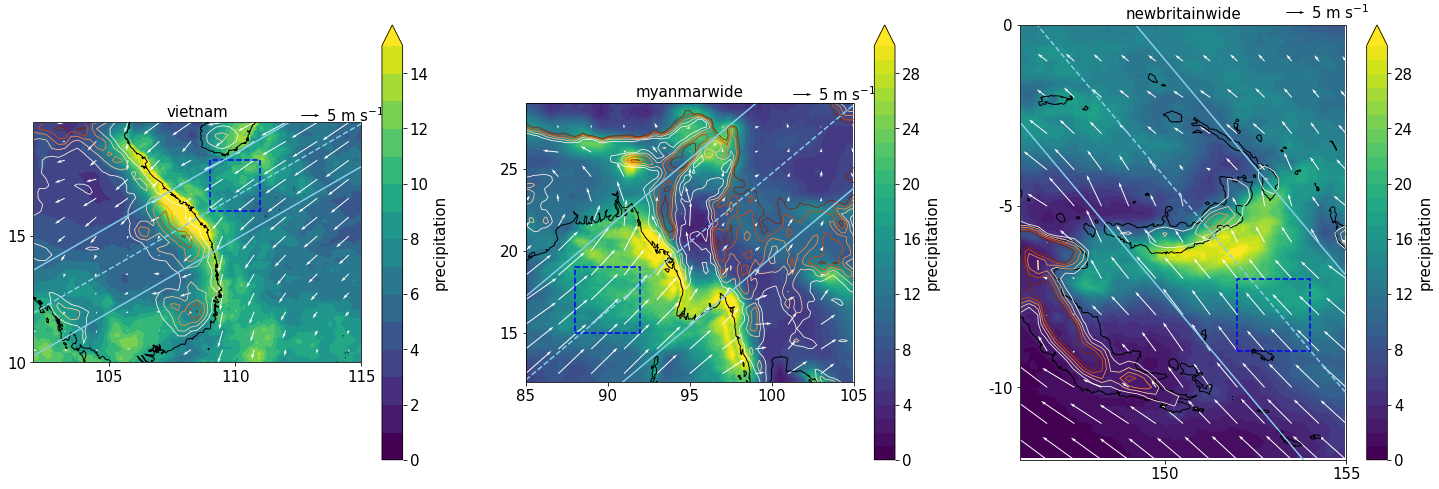

In [41]:
fig,axs = plt.subplots(1,3,figsize=(25,8),subplot_kw={"projection":ccrs.PlateCarree()})
for ax,MR,lev,center,width in zip(axs.reshape(-1),(Vietnam, Myanmarwide, Newbritainwide),(15,30,30),(0.6,0.5,0.6),(0.15,0.2,0.1)):
    topography_pr_wind_plot(ax,MR.box,MR.vars['Z'],MR.vars['GPM_PR'],MR.vars['VAR_100U'],MR.vars['VAR_100V'],np.arange(0,lev+1,1))

    #precipmask.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['w'])

    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=y0*(1-center)+y1*center
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    ax.plot([x0,x1],fx,color='skyblue',linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)*width/np.cos(alpha),color='skyblue',linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)*width/np.cos(alpha),color='skyblue',linestyle='-')
    
    for smallbox,clr in ((MR.box_above,'b'),):
        ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                           edgecolor=clr,
                                           fill = False,
                                           lw=1.5,
                                           linestyle='--',
                                           transform=ccrs.PlateCarree())
                        )

    ax.set_title(MR.name,fontsize=15);None
    
    



# Vietnam

In [21]:
MR = Vietnam

In [22]:
windyspells_start,windyspells_end,windyspells_lengths = get_subspells(MR.vars['UPERPITG_UPSTREAM_DAILY']>9,4)
nspells = len(windyspells_start)
for i in range(nspells):
    days = np.array(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    print("%s - %s, %i-day windy spell, %.2f mm/day, %.2f m/s"%(days_str[0],days_str[-1],windyspells_lengths[i],
                                                                MR.vars['GPMPR_ABOVE_DAILY']  [windyspells_start[i]:windyspells_end[i]].mean('time'),
                                                                MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].mean('time')))

20031002 - 20031005, 4-day windy spell, 28.62 mm/day, 9.99 m/s
20031014 - 20031018, 5-day windy spell, 59.64 mm/day, 10.09 m/s
20051007 - 20051010, 4-day windy spell, 50.04 mm/day, 11.35 m/s
20051018 - 20051023, 6-day windy spell, 12.61 mm/day, 10.40 m/s
20051028 - 20051031, 4-day windy spell, 12.82 mm/day, 15.68 m/s
20061024 - 20061028, 5-day windy spell, 7.78 mm/day, 10.63 m/s
20071021 - 20071026, 6-day windy spell, 5.71 mm/day, 10.58 m/s
20101026 - 20101031, 6-day windy spell, 2.01 mm/day, 10.90 m/s


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


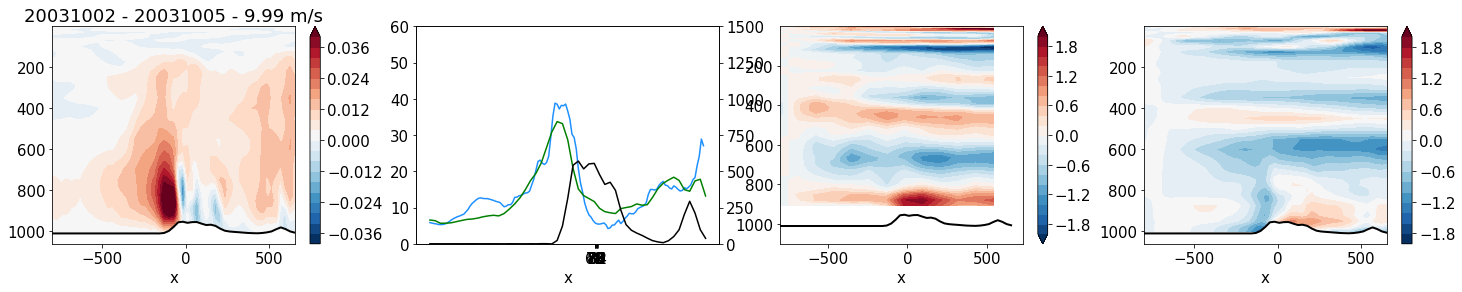

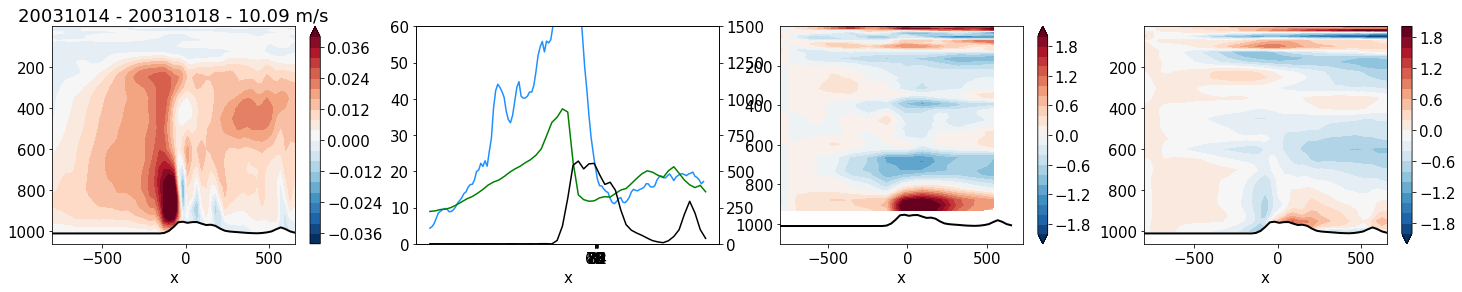

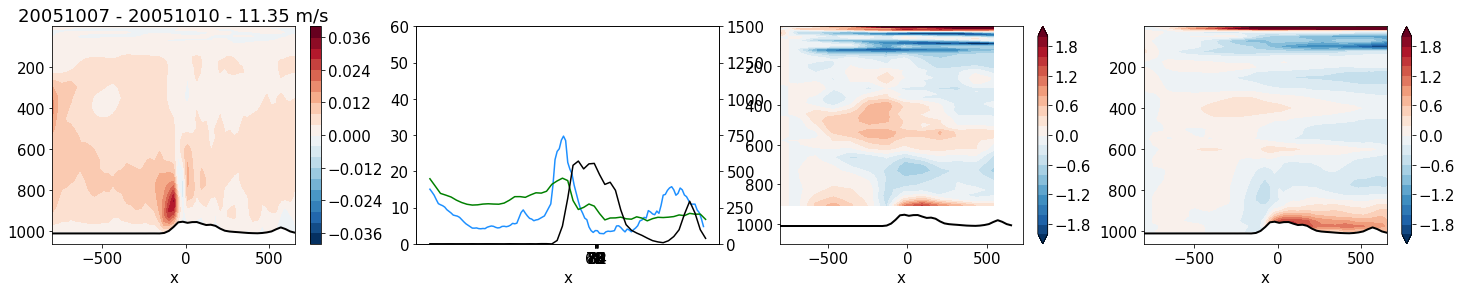

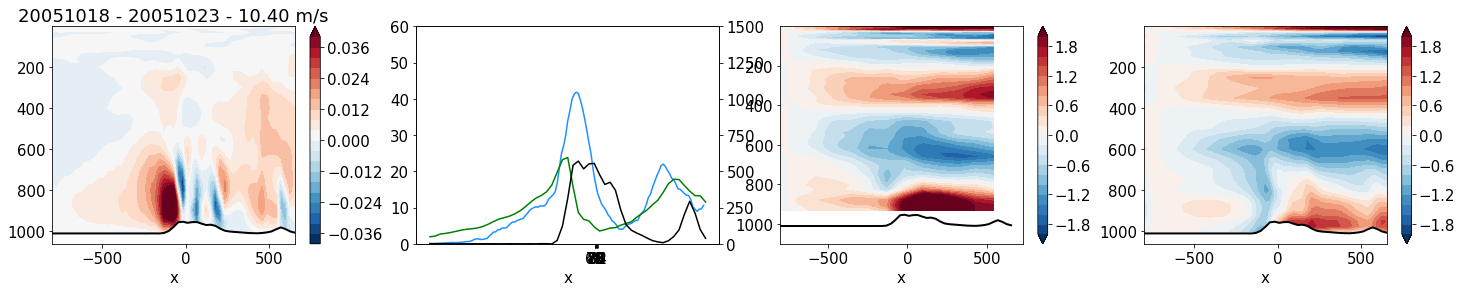

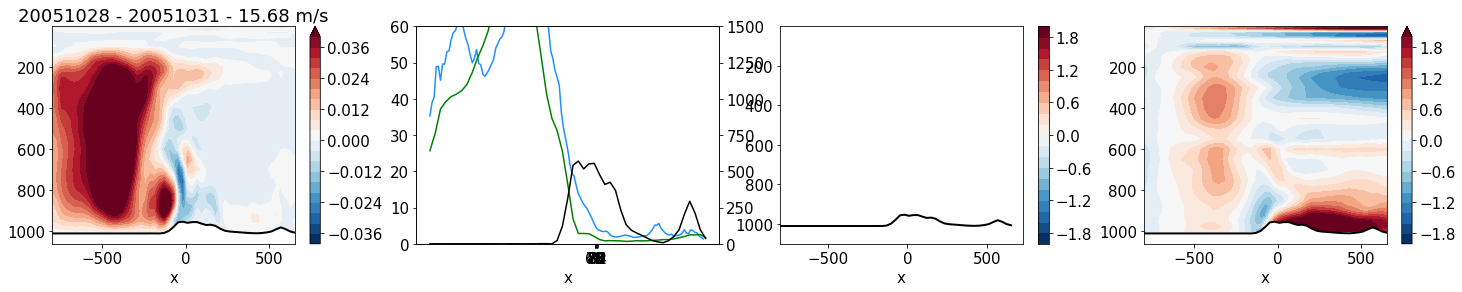

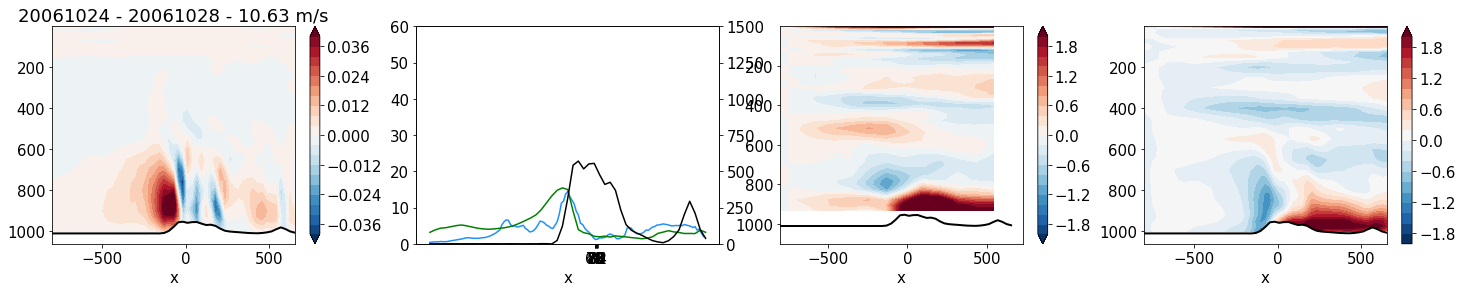

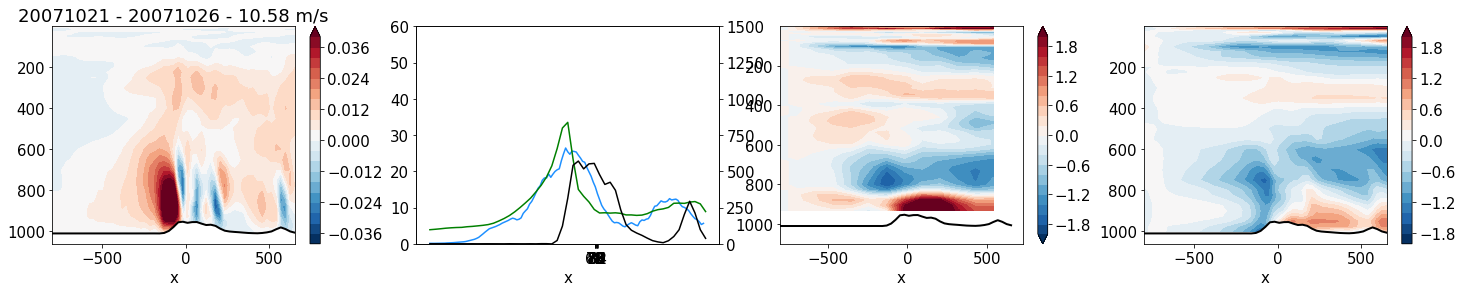

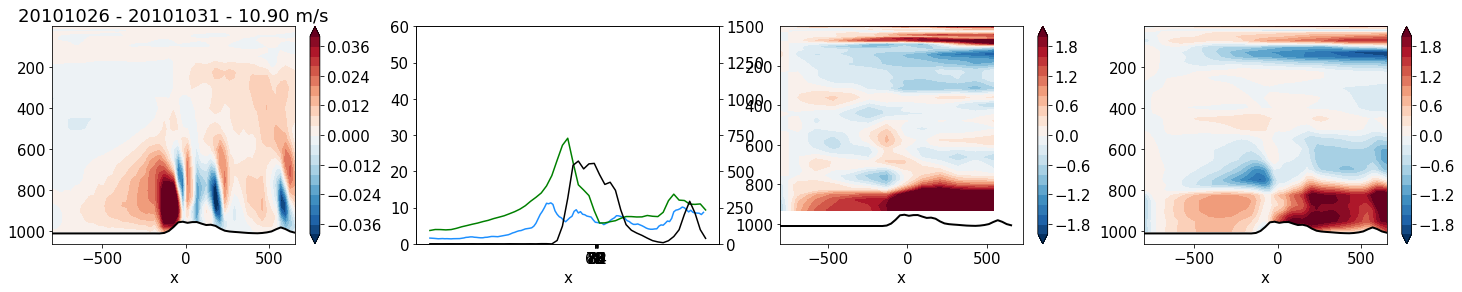

In [23]:
for i in range(nspells):
    days = np.array(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    MR.set_othervar('W_DAILY',MR.vars['W_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5w = crossslope_avg(MR.vars_rot['W_DAILY'],MR.center,MR.width)
    
    MR.set_othervar('T_DAILY',MR.vars['T_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5t = crossslope_avg(MR.vars_rot['T_DAILY'],MR.center,MR.width)
    era5tprime = era5t-era5t.sel(x=slice(era5t.x[0],era5t.x[0]+200)).mean('x')
        
    MR.set_othervar('CLIMCAPST_DAILY_SPEC',MR.vars['CLIMCAPST_DAILY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    airst = crossslope_avg(MR.vars_rot['CLIMCAPST_DAILY_SPEC'],MR.center,MR.width)
    airstprime=airst-airst.sel(x=slice(era5t.x[0],era5t.x[0]+200)).mean('x')

    MR.set_othervar('ERA5PR_DAILY_SPEC',24e3*MR.vars['ERA5PR_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5pr = crossslope_avg(MR.vars_rot['ERA5PR_DAILY_SPEC'],MR.center,MR.width)
    
    MR.set_othervar('GPMPR_DAILY_SPEC',MR.vars['GPMPR_DAILY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    gpmpr = crossslope_avg(MR.vars_rot['GPMPR_DAILY_SPEC'],MR.center,MR.width)
    
    topo = crossslope_avg(MR.vars_rot['Z'],MR.center,MR.width)
    
    _,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,4))
    #W
    (-era5w/10).plot.contourf(ax=ax1,y='level',yincrease=False,levels=np.linspace(-0.04,0.04,21),cmap=plt.cm.RdBu_r)
    
    #PRECIPS
    gpmpr.plot(ax=ax2,label='GPM precip',color='dodgerblue')
    era5pr.plot(ax=ax2,label='ERA5 precip',color='g')
    ax22=ax2.twinx()
    topo.plot(ax=ax22,color='k')
    ax2.set_ylim(0,60)
    ax22.set_ylim(0,1500)
    ax2.set_xticks(np.arange(68,86,2));None
    
    #airs T
    airstprime.plot.contourf(ax=ax3,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)
    #ERA5 T
    era5tprime.plot.contourf(ax=ax4,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)

    for ax in (ax1,ax3,ax4):
        ax.fill_between(topo.x,1010*topo**0,1010-topo/10,color='w')
        (1010-topo/10).plot(ax=ax,color='k',linewidth=2)
    ax1.set_title(days_str[0]+" - "+days_str[-1]+ " - %.2f m/s"%(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].mean('time')))


# Myanmar

In [27]:
MR = Myanmarwide

In [28]:
windyspells_start,windyspells_end,windyspells_lengths = get_subspells(MR.vars['UPERPITG_UPSTREAM_DAILY']>14,6)
nspells = len(windyspells_start)
for i in range(nspells):
    days = np.array(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    print("%s - %s, %i-day windy spell, %.2f mm/day, %.2f m/s"%(days_str[0],days_str[-1],windyspells_lengths[i],
                                                                MR.vars['GPMPR_ABOVE_DAILY'] [windyspells_start[i]:windyspells_end[i]].mean('time'),
                                                                MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].mean('time')))

20010611 - 20010616, 6-day windy spell, 29.20 mm/day, 16.63 m/s
20020808 - 20020816, 9-day windy spell, 22.71 mm/day, 15.66 m/s
20050723 - 20050730, 8-day windy spell, 29.19 mm/day, 16.45 m/s
20070627 - 20070706, 10-day windy spell, 37.22 mm/day, 16.52 m/s
20120725 - 20120730, 6-day windy spell, 28.54 mm/day, 15.01 m/s
20120731 - 20120806, 7-day windy spell, 19.08 mm/day, 15.34 m/s
20150620 - 20150626, 7-day windy spell, 49.83 mm/day, 17.16 m/s
20150726 - 20150731, 6-day windy spell, 44.84 mm/day, 15.74 m/s


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matpl

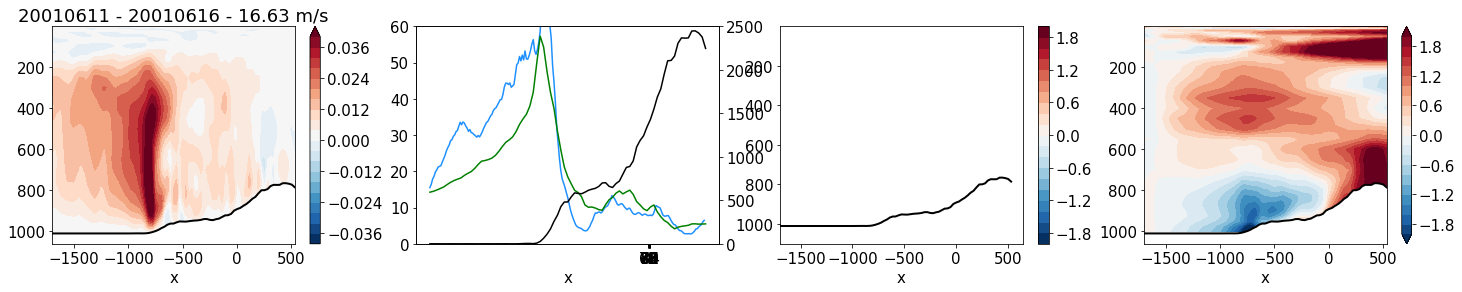

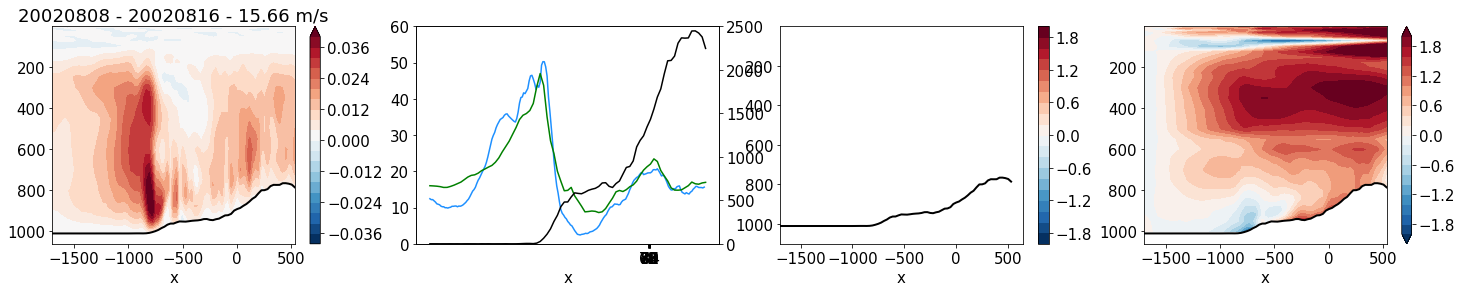

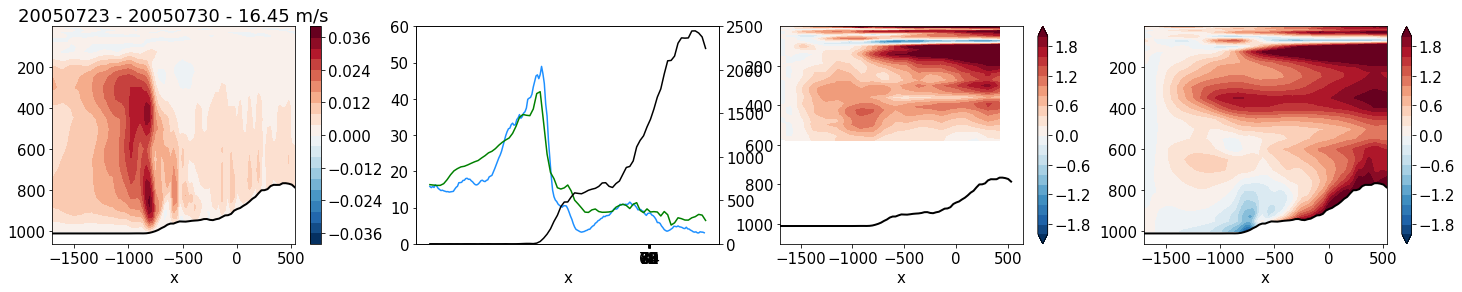

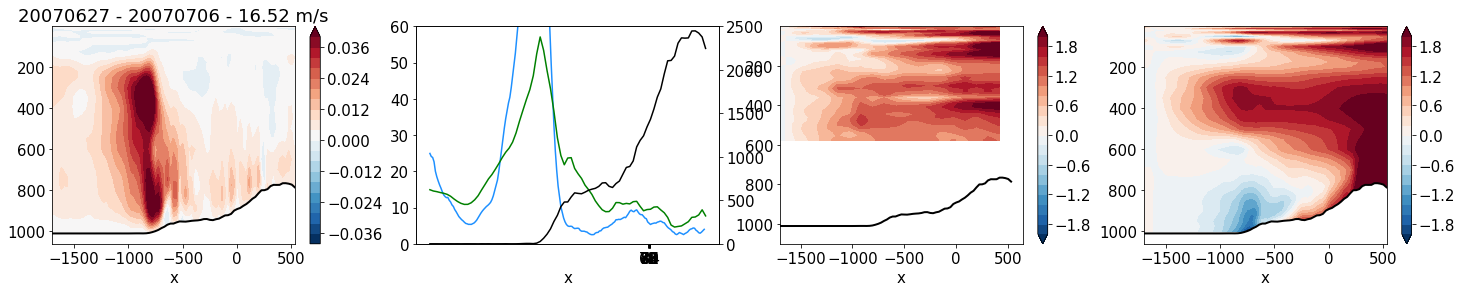

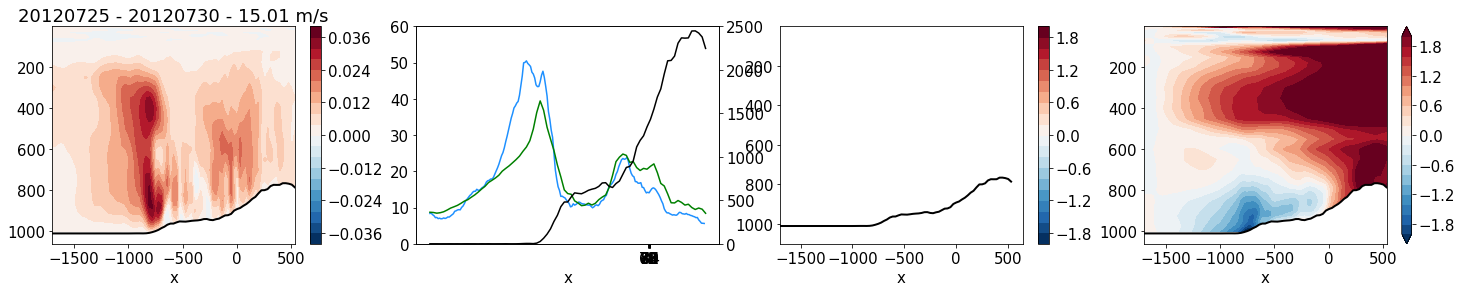

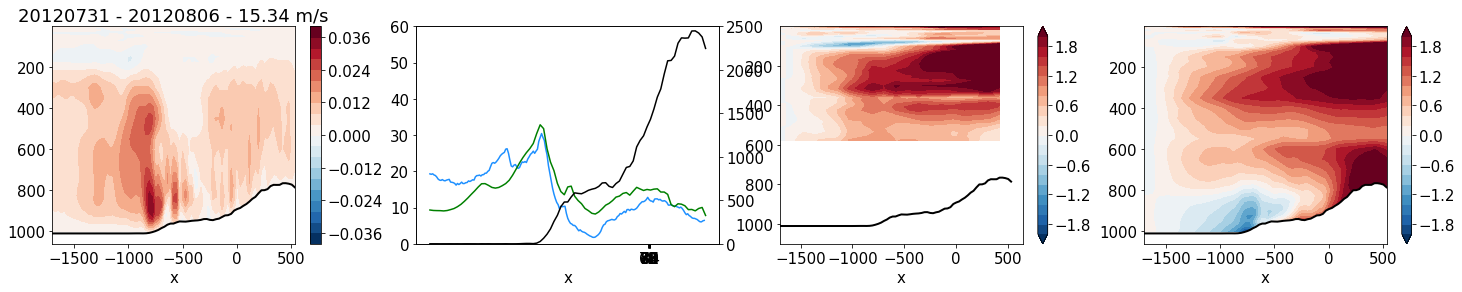

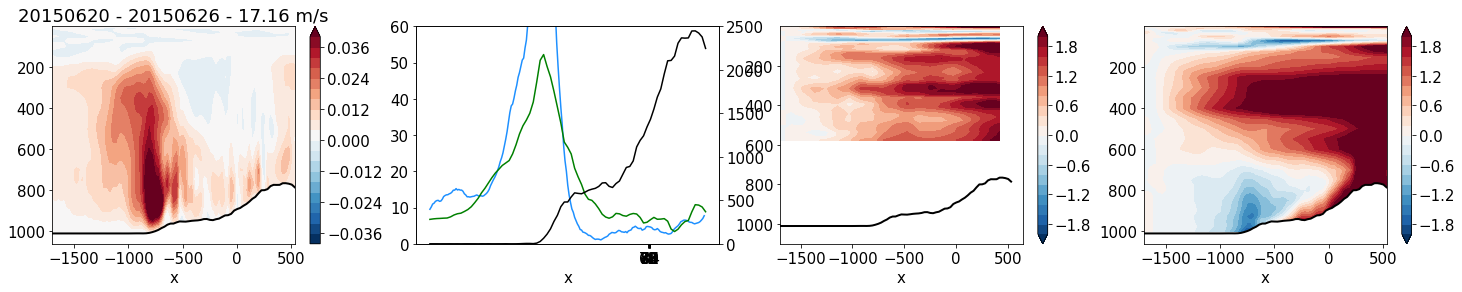

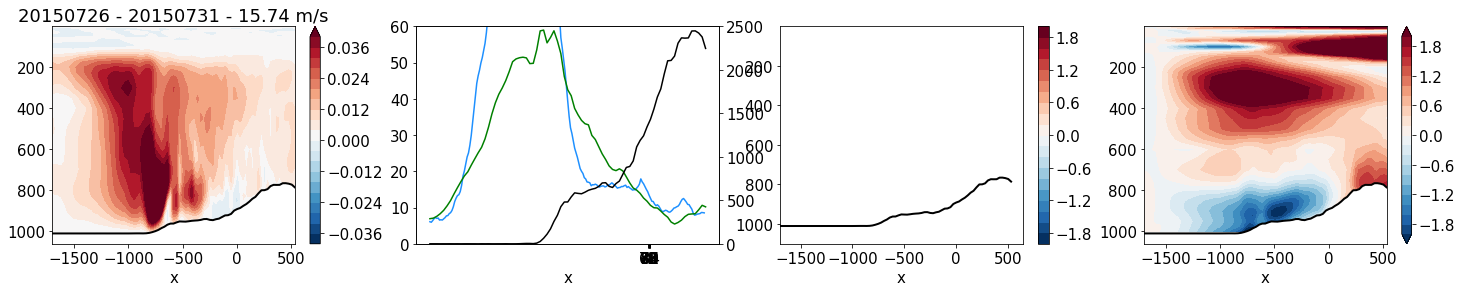

In [29]:
for i in range(nspells):
    days = np.array(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    MR.set_othervar('W_DAILY',MR.vars['W_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5w = crossslope_avg(MR.vars_rot['W_DAILY'],MR.center,MR.width)
    
    MR.set_othervar('T_DAILY',MR.vars['T_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5t = crossslope_avg(MR.vars_rot['T_DAILY'],MR.center,MR.width)
    era5tprime = era5t-era5t.sel(x=slice(era5t.x[0],era5t.x[0]+200)).mean('x')
        
    MR.set_othervar('CLIMCAPST_DAILY_SPEC',MR.vars['CLIMCAPST_DAILY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    airst = crossslope_avg(MR.vars_rot['CLIMCAPST_DAILY_SPEC'],MR.center,MR.width)
    airstprime=airst-airst.sel(x=slice(era5t.x[0],era5t.x[0]+200)).mean('x')

    MR.set_othervar('ERA5PR_DAILY_SPEC',24e3*MR.vars['ERA5PR_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5pr = crossslope_avg(MR.vars_rot['ERA5PR_DAILY_SPEC'],MR.center,MR.width)
    
    MR.set_othervar('GPMPR_DAILY_SPEC',MR.vars['GPMPR_DAILY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    gpmpr = crossslope_avg(MR.vars_rot['GPMPR_DAILY_SPEC'],MR.center,MR.width)
    
    topo = crossslope_avg(MR.vars_rot['Z'],MR.center,MR.width)
    
    _,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,4))
    #W
    (-era5w/10).plot.contourf(ax=ax1,y='level',yincrease=False,levels=np.linspace(-0.04,0.04,21),cmap=plt.cm.RdBu_r)
    
    #PRECIPS
    gpmpr.plot(ax=ax2,label='GPM precip',color='dodgerblue')
    era5pr.plot(ax=ax2,label='ERA5 precip',color='g')
    ax22=ax2.twinx()
    topo.plot(ax=ax22,color='k')
    ax2.set_ylim(0,60)
    ax22.set_ylim(0,2500)
    ax2.set_xticks(np.arange(68,86,2));None
    
    #airs T
    airstprime.plot.contourf(ax=ax3,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)
    #ERA5 T
    era5tprime.plot.contourf(ax=ax4,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)

    for ax in (ax1,ax3,ax4):
        ax.fill_between(topo.x,1010*topo**0,1010-topo/10,color='w')
        (1010-topo/10).plot(ax=ax,color='k',linewidth=2)
    ax1.set_title(days_str[0]+" - "+days_str[-1]+ " - %.2f m/s"%(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].mean('time')))


# New Britain

In [30]:
MR = Newbritainwide

In [33]:
windyspells_start,windyspells_end,windyspells_lengths = get_subspells(MR.vars['UPERPITG_UPSTREAM_DAILY']>9,4)
nspells = len(windyspells_start)
for i in range(nspells):
    days = np.array(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    print("%s - %s, %i-day windy spell, %.2f mm/day, %.2f m/s"%(days_str[0],days_str[-1],windyspells_lengths[i],
                                                                MR.vars['GPMPR_ABOVE_DAILY'] [windyspells_start[i]:windyspells_end[i]].mean('time'),
                                                                MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].mean('time')))

20010810 - 20010815, 6-day windy spell, 64.28 mm/day, 10.28 m/s
20030704 - 20030707, 4-day windy spell, 79.35 mm/day, 10.62 m/s
20060820 - 20060823, 4-day windy spell, 50.57 mm/day, 10.67 m/s
20100728 - 20100801, 5-day windy spell, 13.83 mm/day, 9.66 m/s
20110702 - 20110705, 4-day windy spell, 57.02 mm/day, 9.83 m/s
20110731 - 20110805, 6-day windy spell, 35.30 mm/day, 10.34 m/s
20130707 - 20130711, 5-day windy spell, 39.60 mm/day, 10.81 m/s
20140630 - 20140703, 4-day windy spell, 32.99 mm/day, 9.72 m/s


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matpl

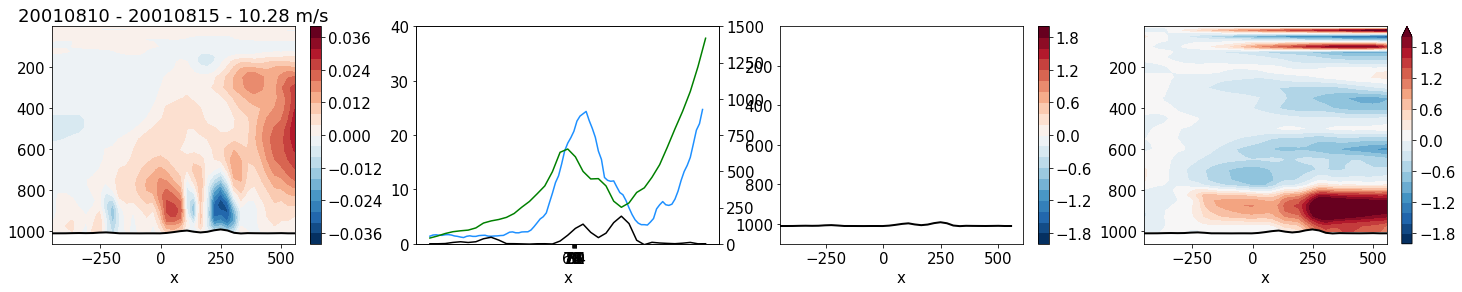

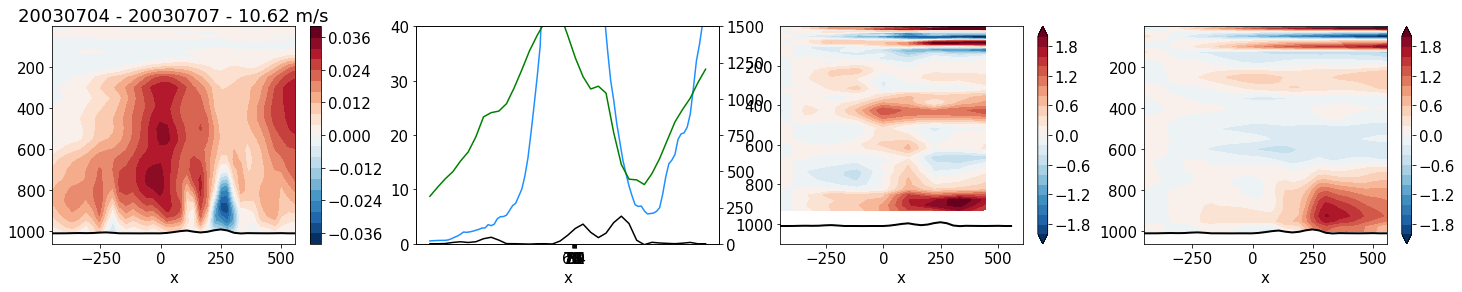

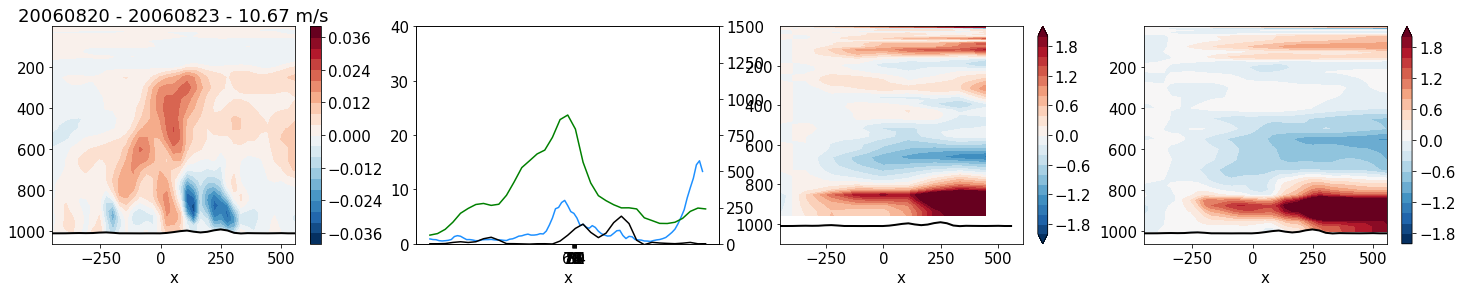

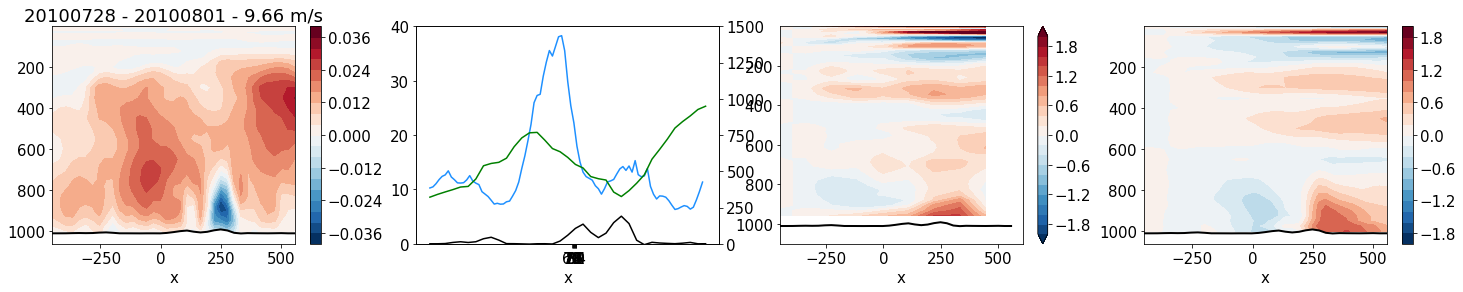

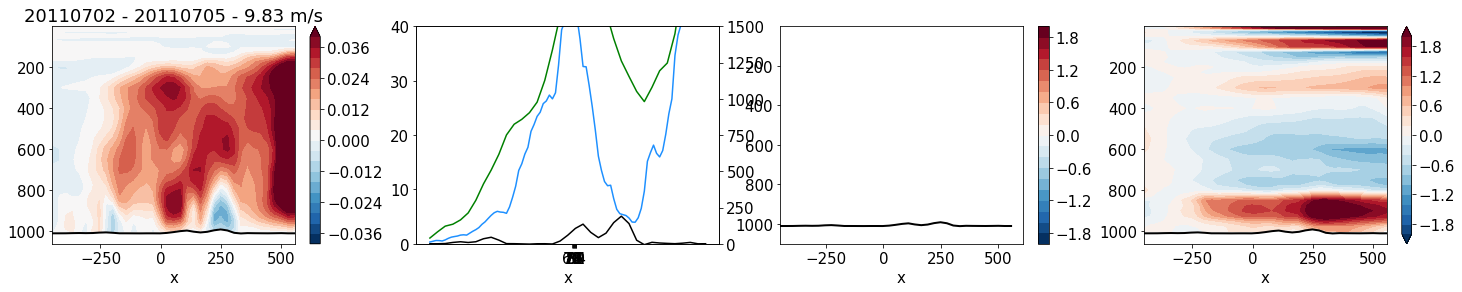

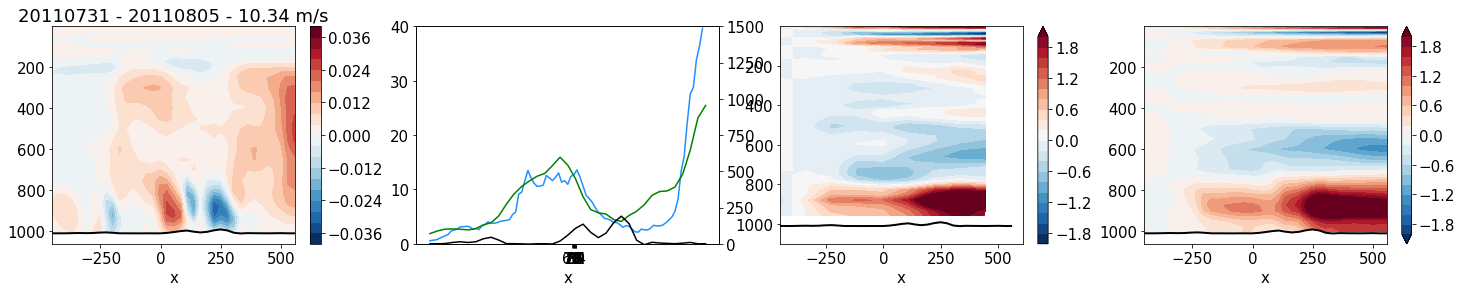

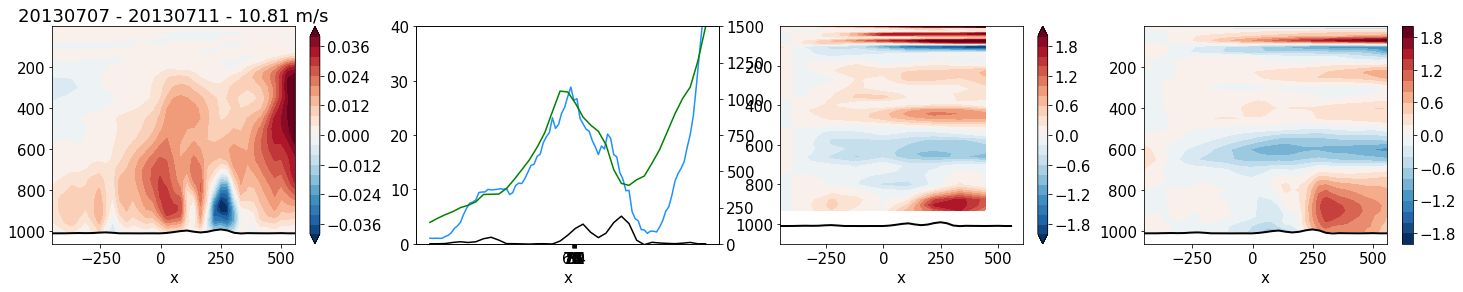

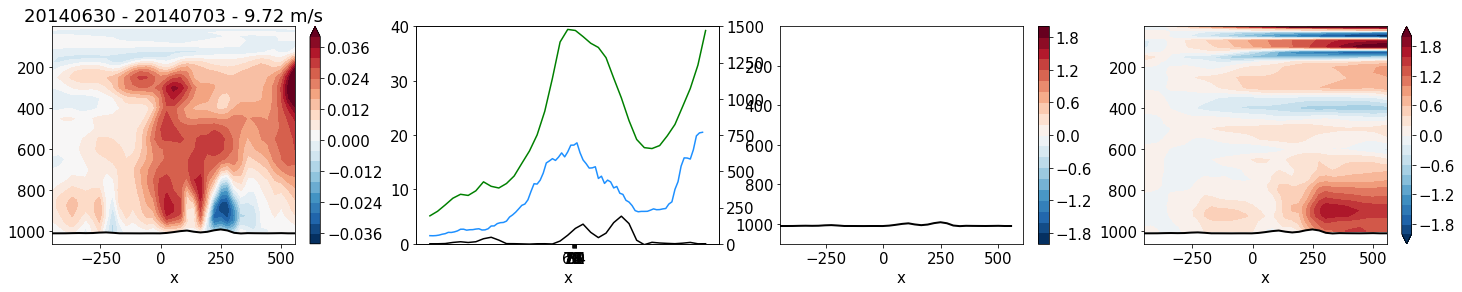

In [35]:
for i in range(nspells):
    days = np.array(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    MR.set_othervar('W_DAILY',MR.vars['W_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5w = crossslope_avg(MR.vars_rot['W_DAILY'],MR.center,MR.width)
    
    MR.set_othervar('T_DAILY',MR.vars['T_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5t = crossslope_avg(MR.vars_rot['T_DAILY'],MR.center,MR.width)
    era5tprime = era5t-era5t.sel(x=slice(era5t.x[0],era5t.x[0]+200)).mean('x')
        
    MR.set_othervar('CLIMCAPST_DAILY_SPEC',MR.vars['CLIMCAPST_DAILY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    airst = crossslope_avg(MR.vars_rot['CLIMCAPST_DAILY_SPEC'],MR.center,MR.width)
    airstprime=airst-airst.sel(x=slice(era5t.x[0],era5t.x[0]+200)).mean('x')

    MR.set_othervar('ERA5PR_DAILY_SPEC',24e3*MR.vars['ERA5PR_HOURLY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    era5pr = crossslope_avg(MR.vars_rot['ERA5PR_DAILY_SPEC'],MR.center,MR.width)
    
    MR.set_othervar('GPMPR_DAILY_SPEC',MR.vars['GPMPR_DAILY'].sel(time=slice(days_str[0],days_str[-1])).mean(['time']))
    gpmpr = crossslope_avg(MR.vars_rot['GPMPR_DAILY_SPEC'],MR.center,MR.width)
    
    topo = crossslope_avg(MR.vars_rot['Z'],MR.center,MR.width)
    
    _,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,4))
    #W
    (-era5w/10).plot.contourf(ax=ax1,y='level',yincrease=False,levels=np.linspace(-0.04,0.04,21),cmap=plt.cm.RdBu_r)
    
    #PRECIPS
    gpmpr.plot(ax=ax2,label='GPM precip',color='dodgerblue')
    era5pr.plot(ax=ax2,label='ERA5 precip',color='g')
    ax22=ax2.twinx()
    topo.plot(ax=ax22,color='k')
    ax2.set_ylim(0,40)
    ax22.set_ylim(0,1500)
    ax2.set_xticks(np.arange(68,86,2));None
    
    #airs T
    airstprime.plot.contourf(ax=ax3,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)
    #ERA5 T
    era5tprime.plot.contourf(ax=ax4,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)

    for ax in (ax1,ax3,ax4):
        ax.fill_between(topo.x,1010*topo**0,1010-topo/10,color='w')
        (1010-topo/10).plot(ax=ax,color='k',linewidth=2)
    ax1.set_title(days_str[0]+" - "+days_str[-1]+ " - %.2f m/s"%(MR.vars['UPERPITG_UPSTREAM_DAILY'][windyspells_start[i]:windyspells_end[i]].mean('time')))


# Old Soundings

(-1.8, 1.8)

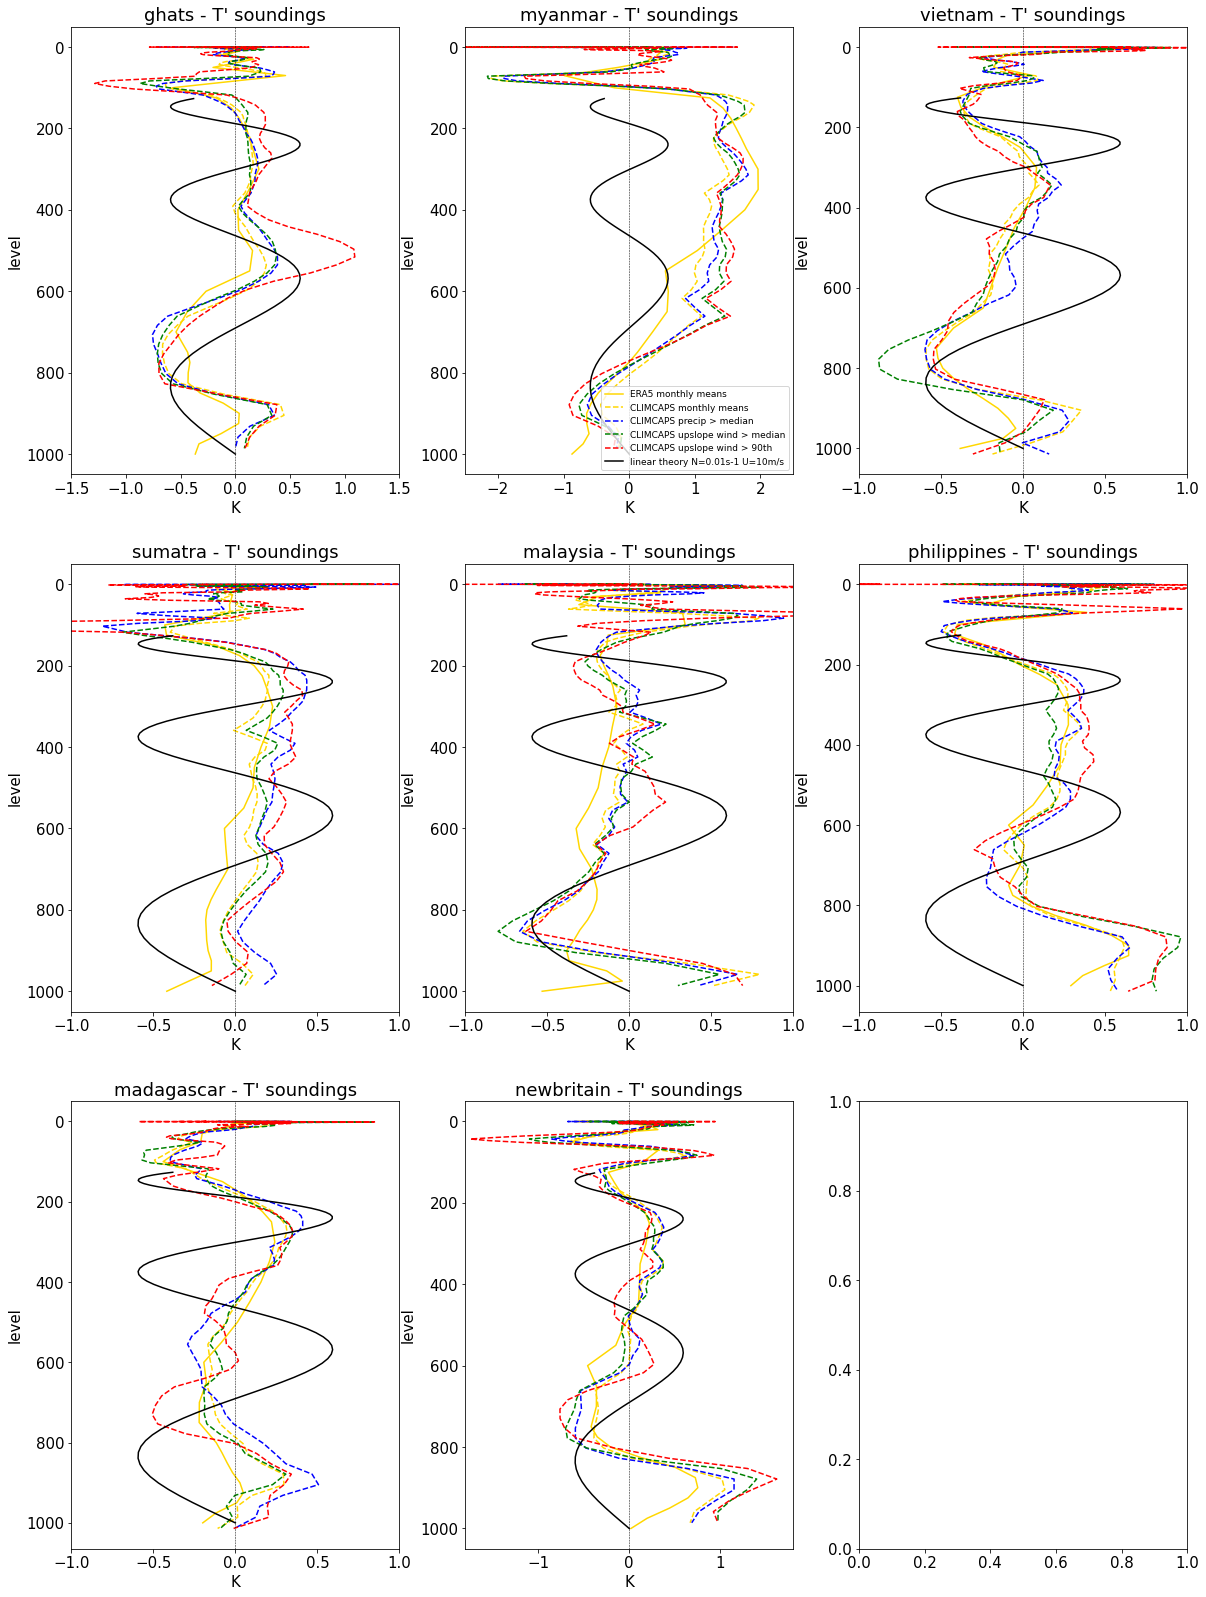

In [63]:
unit = 'K'
fig,axs = plt.subplots(3,3,figsize=(20,28))

with warnings.catch_warnings():
    warnings.simplefilter("ignore",RuntimeWarning)
    for ax,MR in zip(axs.reshape(-1)[:-1],(Ghats,Myanmar,Vietnam,Sumatra,Malaysia,Philippines,Madagascar, Newbritain)):
        plot_z_diff(ax,MR.vars['T']              ,MR.box_upstream,MR.box_above,color='gold' ,label='ERA5 monthly means')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T']     ,MR.box_upstream,MR.box_above,color='gold' ,linestyle='--',label='CLIMCAPS monthly means')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T_PR50'],MR.box_upstream,MR.box_above,color='blue' ,linestyle='--',label='CLIMCAPS precip > median')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T_U50'] ,MR.box_upstream,MR.box_above,color='green',linestyle='--',label='CLIMCAPS upslope wind > median')
        plot_z_diff(ax,MR.vars['CLIMCAPS_T_U90'] ,MR.box_upstream,MR.box_above,color='r',linestyle='--',label='CLIMCAPS upslope wind > 90th')
        ax.plot(linear_Td_10,linear_Td_10.pressure,color='k',label = 'linear theory N=0.01s-1 U=10m/s' )
        ax.set_title("%s - T' soundings"%MR.name)
        ax.set_xlabel(unit)
        ax.axvline(0.,color='k',linestyle='--',linewidth=0.5)
        ax.set_xlim(-1,1)
axs[0,1].legend(fontsize=9,loc=4)
axs[0,0].set_xlim(-1.5,1.5)
axs[0,1].set_xlim(-2.5,2.5)
axs[2,1].set_xlim(-1.8,1.8)

